In [122]:
import pandas as pd
import numpy as np
import seaborn as sns

In [123]:
users = pd.read_csv('users_.csv')
purchases = pd.read_csv('purchases_.csv')

## Задание 1

Был запущен сплит-тест (а/б-тест), направленный на улучшение платежной активности пользователей. Вам дан датасет с транзакциями пользователей до и во время теста в контрольной и тестовых группах

1. Какие вы можете сделать выводы? Какая группа показала лучшие результаты?

### Разведочный анализ данных

In [124]:
display(users.head(), purchases.head())

,tag,ts,user_uid,registration_time,conv_ts
0,test4,30152.843868,001885550d78efd82c0f5cc02ad3369a,27410.154590,29485.529691
1,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734
2,test1,30140.447675,32095e22f853e595a0f407ad081e7da8,27410.217536,27414.028899
3,control,30136.790772,9932d33f40ad07d7f3ddb7c6aee1bc60,27410.227367,27573.751226
4,test2,30150.339264,4a122db1ad0214e969df154d2dbb4622,27410.230786,29545.833019


,user_uid,time,consumption_mode,element_uid,price
0,d60a7038c7b7e99146ffea6f6535862b,30158.645112,dto,2ba66ac9785731da67b2b6155efaca5c,44.470588
1,0906074e1a1a9229b5e749860b646962,30158.645015,dto,e56d422275d90c96762f81db85d80f3d,38.588235
2,efb6eeca3135d573739e5c5d4dbce330,30158.644990,dto,544f7dd31bd61558c9c738adcff6aafa,50.352941
3,ccd658e372645c991ce49b444839712f,30158.644789,dto,8256d0fc7b25382aacfec0066e39cde3,44.470588
4,89ae5e43ff7b89f9d262d507dedc1760,30158.644200,dto,a579f32b5c116624cc661c9d3b96d5e5,44.470588


In [125]:
display(users.info(), purchases.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696982 entries, 0 to 696981
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tag                696982 non-null  object 
 1   ts                 696982 non-null  float64
 2   user_uid           696982 non-null  object 
 3   registration_time  696485 non-null  float64
 4   conv_ts            696697 non-null  float64
dtypes: float64(3), object(2)
memory usage: 26.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663849 entries, 0 to 663848
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_uid          663849 non-null  object 
 1   time              663849 non-null  float64
 2   consumption_mode  663849 non-null  object 
 3   element_uid       663849 non-null  object 
 4   price             663849 non-null  float64
dtypes: float64(2), object(3)
memory usage: 25.3

None

None

#### Проверка наличия дубликатов и логических ошибок

In [126]:
users['user_uid'].duplicated().value_counts()

user_uid
False    694819
True       2163
Name: count, dtype: int64

In [127]:
2163/694819 * 100

0.31130409502330825

Дубликаты занимают 0.3% от выборки, считаю возможным удалить их без сильного влияения на оценку. Первая идея была оставить строки с максимумом по ts но некотрорые юзеры попали в разные группы, что выглядит странно, поэтому вижу целесообразнее дубликаты просто удалить

In [128]:
users.drop_duplicates(['user_uid'], inplace=True)

Проверим нет ли строк, где время регистрации пользователя позднее чем время появления в тесте

In [129]:
users.query('registration_time > ts')

,tag,ts,user_uid,registration_time,conv_ts
1308,control,30132.530282,509b44822a9ec9b6f96c01d118176faf,30244.874660,30046.187656
14137,test3,30144.708921,1cd7770bba07ac2dd5152751b5ac5aac,30238.227555,30142.347016
28157,test1,30132.469814,d6d1be3a09a0ca4bf42988176477d3df,30243.051099,29793.565608
28947,test1,30150.216191,b5bb0bd4fc9f3731f824dc854349706b,30246.250068,29831.051460
37621,test1,30140.000534,c5101de8fdfb1e3cc551e525f32e2a93,30245.979976,NaN
...,...,...,...,...,...
658315,control,30156.679669,a6522659b4767c3ba4c633b488859c31,30245.829571,NaN
672977,test1,30135.189462,cfcde41c21342d9c832c98ce94dfa206,30157.210560,29430.115823
678593,test4,30158.349019,bb4a90d22d55de54544108cf0bd11ec5,30201.924673,30155.385573
691061,control,30133.983285,5a2f92f89f349fb4565f5dc4d4ff09db,30236.433278,27531.375915


Считаю эти данные ошибками, удаляю из датасета. 

In [130]:
users = users.query('registration_time <= ts')

Убедимся, что время начала аб теста примерно равно по группам:

In [131]:
users[['tag', 'ts']].groupby('tag').mean()

,ts
tag,
control,30141.120219
test1,30141.144924
test2,30141.146088
test3,30141.156612
test4,30141.155692


### Определение метрик

За метрики предлагаю взять: 
1. **total_pay_user_rate** - доля пользователей, которые совершили какую-либо платежную активность
2. **sub_user_rate** доля клиентов, которые хотя бы раз приобретали подписку за время теста
3. **total_revenue** - общий доход
4. **avg_check** - средние траты пользователя
5. **avg_check_no_sub** - средние траты пользователя без учета подписок

In [132]:
#для расчета метрик смерджим таблицы
df_merged = pd.merge(users, purchases
         , left_on='user_uid'
         , right_on='user_uid'
         , how='left')

#Разделим датафрейм на тестовый и до-тестовый
test_df = df_merged.query('time >= ts')
pre_test_df = df_merged.query('time < ts')

#также посчитаем знаменатель для 1 и 2 метрик (общее кол-во юзеров по группам)
total_count = users[['tag', 'user_uid']].groupby('tag').count().rename(columns={'user_uid' : 'total_count'})

#в test_df находятся только инфо о юзерах, которые соверащил платежную активность
#поэтому для расчета 1 метрики посчиатем кол-во уникальных пользователей в test_df
pay_users = test_df.drop_duplicates('user_uid')[['tag'
                                                 , 'user_uid']].groupby('tag').count()
pay_users.rename(columns={'user_uid' : 'pay_users'}, inplace=True)

#считаем то же самое, но для метрики 2 (фильтруем юзеров с подпиской)
sub_users = test_df.query('consumption_mode == "subscription"').drop_duplicates('user_uid')[['tag'
                                                                                             , 'user_uid']].groupby('tag').count()
sub_users.rename(columns={'user_uid' : 'sub_users'}, inplace=True)

#общий доход
total_revenue = test_df[['tag', 'price']].groupby('tag').sum().rename(columns={'price' : 'total_revenue'})

#средние траты пользователя
revenue_by_user = test_df[['tag'
                           , 'user_uid'
                           , 'price']].groupby(['tag'
                                                , 'user_uid']
                                               , as_index=False).sum()
avg_check = revenue_by_user[['tag', 'price']].groupby('tag').mean().rename(columns={'price' : 'avg_check'})

#средние траты пользователя без учета подписок
no_sub_revenue_by_user = test_df.query('consumption_mode != "subscription"')[['tag'
                                                                       , 'user_uid'
                                                                       , 'price']].groupby(['tag'
                                                                                            , 'user_uid']
                                                                                           , as_index=False).sum()
avg_check_no_sub = no_sub_revenue_by_user[['tag', 'price']].groupby('tag').mean().rename(columns={'price' : 'avg_check_no_sub'})


In [133]:
#соберем все метрики в один датафрейм

metrics = pd.concat([total_count
                     , pay_users
                     , sub_users
                     , total_revenue
                     , avg_check
                     , avg_check_no_sub]
                     , axis=1)
metrics['total_pay_user_rate'] = (metrics['pay_users'] / metrics['total_count'] * 100).round(2)
metrics['sub_user_rate'] = (metrics['sub_users'] / metrics['total_count'] * 100).round(2)

metrics

,total_count,pay_users,sub_users,total_revenue,avg_check,avg_check_no_sub,total_pay_user_rate,sub_user_rate
tag,,,,,,,,
control,138441,30004,14655,2.046498e+06,68.207521,60.928142,21.67,10.59
test1,139525,31424,15086,2.168200e+06,68.998209,61.344948,22.52,10.81
test2,138844,31001,14836,2.148779e+06,69.313229,61.750009,22.33,10.69
test3,138688,31076,15043,2.158072e+06,69.444979,61.823891,22.41,10.85
test4,138694,31104,14776,2.148968e+06,69.089761,61.359571,22.43,10.65


In [134]:
tag_list = metrics.index.to_list()[1:]
tag_list

['test1', 'test2', 'test3', 'test4']

<Axes: >

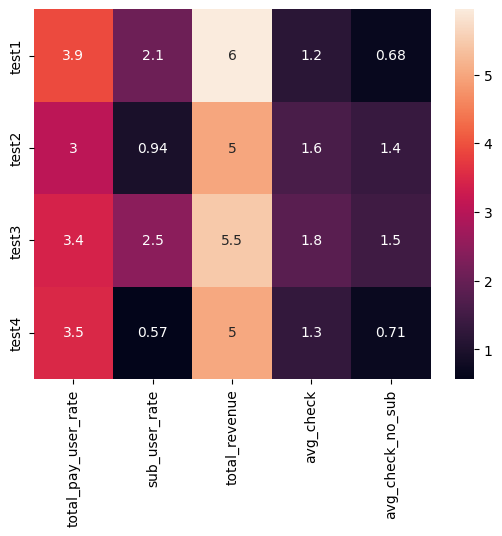

In [135]:
#посчитаем аплифт каждой метрики
metrics_list = ['total_pay_user_rate', 'sub_user_rate', 'total_revenue', 'avg_check', 'avg_check_no_sub']

df_rows = []
for tag in tag_list:
    df_row = []
    for metric in metrics_list:
        uplift = round((metrics.loc[tag][metric] - metrics.loc['control'][metric]) \
                        / metrics.loc['control'][metric] * 100, 2)
        df_row.append(uplift)
    df_rows.append(df_row)

metrics_uplift = pd.DataFrame(data=df_rows, index=tag_list, columns=metrics_list)

sns.heatmap(metrics_uplift, annot=True)

### Вывод

В первой тестовой группе доля клиентов с платежной активностью имеет наибольший аплифт
То же самое относится и к общей выручке

Но доля пользователей, оформивших подписку, и размер средних трат пользователя имеет наивысший аплифт в третьей тестовой группе

Таким образом нам необходима дополнительная информация о доходности по продуктам 

**Если для сервиса ценнее подписчики, то третья группа показывает наилучший результат**

## Задание 2

2. Можем ли мы как-то оценить из этих данных равномерность и валидность распределения юзеров по разным группам?

Равномерность можно оценить сл образом:
1. Оценить кол-во общего числа пользователей в каждой группе
2. Посчитать метрики на данных до проведения теста

In [136]:
users[['tag', 'user_uid']].groupby('tag').count()

,user_uid
tag,
control,138441
test1,139525
test2,138844
test3,138688
test4,138694


Число пользователей по группам примерно одинаковое

In [137]:
#Копируем код, который был немного ниже, но меняем test_df на pre_test_df

total_count = users[['tag', 'user_uid']].groupby('tag').count().rename(columns={'user_uid' : 'total_count'})


pay_users = pre_test_df.drop_duplicates('user_uid')[['tag'
                                                 , 'user_uid']].groupby('tag').count()
pay_users.rename(columns={'user_uid' : 'pay_users'}, inplace=True)

revenue_by_user = pre_test_df[['tag'
                           , 'user_uid'
                           , 'price']].groupby(['tag'
                                                , 'user_uid']
                                               , as_index=False).sum()
avg_check = revenue_by_user[['tag', 'price']].groupby('tag').mean().rename(columns={'price' : 'avg_check'})

metrics_pre_test = pd.concat([total_count
                              , pay_users
                              , avg_check]
                             , axis=1)
metrics_pre_test['total_pay_user_rate'] = (metrics_pre_test['pay_users'] / metrics_pre_test['total_count'] * 100).round(2)

metrics_pre_test

,total_count,pay_users,avg_check,total_pay_user_rate
tag,,,,
control,138441,46113,60.044812,33.31
test1,139525,46710,59.915564,33.48
test2,138844,46179,60.062185,33.26
test3,138688,46021,59.982757,33.18
test4,138694,45913,59.919901,33.10


Средний чек и доля пользователей с платежной активностью имеют близкие значения у групп

Для оценки валидности данных я бы добавил персональные данные пользователей, например пол и возраст
Так мы сможем убедиться в том, что сегменты клиентов имеют одинаковую репрезентацию

## Задание 3

3. Если не ограничиваться теми данными, которые приведены в рамках этого задания, что ещё вы бы посчитали для оценки результатов групп?

Ответ: я бы подробнее изучил разные виды подписок (1 месяц или более долгосрочные) для того, чтобы оценить Retention